# Relax Inc. Data Science Challenge

### Overview: Using two csv files provided for the challenge, define 'adopted_user' as a user who has logged   into the product on three separate days in at least one seven day period. Identify which variables predict user adoption. 

## 1. Data Wrangling/Cleaning: 
- Import libraries
- load data to dataframes
- create 'adopted_user' variable 

## 2. Exploratory Data Analysis
- Explore which variables have strong correlation to the target variable
- Prepare dataset for baseline model(Classification). 

## 3. Baseline Modeling
- Build model
- Gather classification report/accuracy rating
- determine feature importance

## 4. Suggestions 
- outline future steps and further modeling ideas 


## Data Wrangling

In [199]:
#import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
#load csv files to dataframes
df_users = pd.read_csv('takehome_users.csv', encoding='latin_1')#change encoding parameter to 'latin_1' due to UnicodeDecodeError
df_user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [200]:
#get info on users df
df_users.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [201]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


We can see that we have null values in the 'last_session_creation_time' and 'invited_by_user_id' columns.

In [202]:
#get info on user_engagement df
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [203]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


We can see there are no null values in the user_engagement dataset. 

In [204]:
#handle missing values in other column of users df by changing NaN values to 0 if there was no one who invited them
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].fillna(0)
df_users['invited_by_user_id'].isna().sum()

0

#### Creating our variable 'adopted_user' can be done by determining the number of unique users there are in the user engagement df, calculating which of those users login 3 times in at least one week, and creating a boolean value for whether or not the user fits that criteria. 

In [205]:
#check how many unique users there are 
users = df_user_engagement['user_id'].nunique()
logins = len(df_user_engagement)
avg_logins = logins/users
print('There are', users, 'that average', avg_logins, 'logins from', min(df_user_engagement['time_stamp']), 'to', max(df_user_engagement['time_stamp']))

There are 8823 that average 23.565340587101893 logins from 2012-05-31 08:20:06 to 2014-06-06 14:58:50


In [206]:
#convert timestamp to datetime object and set as index
df_user_engagement['time_stamp'] = pd.to_datetime(df_user_engagement['time_stamp'])

In [207]:
#define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [208]:
# run the function on all users
adopted = df_user_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [209]:
#print out number of adopted users
print('There are {} adopted users out of {} users.'.format(sum(adopted), len(adopted)))

There are 1656 adopted users out of 8823 users.


We have learned that out of 8823 users, there are roughly 1656 who have logged in at least 3 separate days in a weekly period. The ratio between adopted_users and non adopted_users provides significant imbalance for this predictor variable and will need to be dealt with during modeling. Let's see what other features we can derive from the user dataframe. 

In [210]:
#find length of time between creation time and last_session_creation_time to determine account_duration
#convert to datetime objects
df_users['creation_time'] = pd.to_datetime(
    df_users['creation_time'], format='%Y-%m-%d %H:%M:%S')
df_users['last_session_creation_time'] = pd.to_datetime(
    df_users['last_session_creation_time'], unit='s')

In [214]:
#convert any NaN values to the creation_time of that user
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].fillna(df_users['creation_time'])
df_users[['last_session_creation_time', 'creation_time']]
df_users['account_duration'] = max(df_users['creation_time']) - df_users['creation_time']
df_users['account_duration'] = df_users['account_duration'].dt.days
df_users['account_duration']

0         38
1        196
2        437
3        374
4        498
        ... 
11995    266
11996    505
11997     33
11998    729
11999    124
Name: account_duration, Length: 12000, dtype: int64

In [216]:
#drop the two columns as we have found a better representation of their information 
df_users = df_users.drop(df_users[['last_session_creation_time', 'creation_time']], axis=1)
df_users

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_duration
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,196
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,437
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,374
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,498
...,...,...,...,...,...,...,...,...,...
11995,11996,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,0,0,89,8263.0,266
11996,11997,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,505
11997,11998,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1,1,83,8074.0,33
11998,11999,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,0,0,6,0.0,729


In [217]:
#on second thought, let's drop 'name' and 'email' as well. We could parse the email source (ie. google, yahoo, etc)
#from the email column, but it shouldn't have too big of an impact. 
df_users = df_users.drop(df_users[['name', 'email']], axis=1)

In [220]:
#merge df_users and adopted 
#df_users = df_users.set_index('object_id')
#df_users.index.name = 'user_id'
df_adopted = pd.concat([df_users, adopted], axis=1, join='inner')
df_adopted

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_duration,adopted_user
user_id,,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,38,False
2,ORG_INVITE,0,0,1,316.0,196,True
3,ORG_INVITE,0,0,94,1525.0,437,False
4,GUEST_INVITE,0,0,1,5151.0,374,False
5,GUEST_INVITE,0,0,193,5240.0,498,False
...,...,...,...,...,...,...,...
11996,ORG_INVITE,0,0,89,8263.0,266,False
11997,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,505,False
11998,GUEST_INVITE,1,1,83,8074.0,33,False


In [228]:
#convert 'adopted_user' to int()
df_adopted['adopted_user'] = df_adopted['adopted_user'].map(lambda x: 1 if x == True else 0)
df_adopted

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_duration,adopted_user
user_id,,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,38,0
2,ORG_INVITE,0,0,1,316.0,196,1
3,ORG_INVITE,0,0,94,1525.0,437,0
4,GUEST_INVITE,0,0,1,5151.0,374,0
5,GUEST_INVITE,0,0,193,5240.0,498,0
...,...,...,...,...,...,...,...
11996,ORG_INVITE,0,0,89,8263.0,266,0
11997,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,505,0
11998,GUEST_INVITE,1,1,83,8074.0,33,0


## Exploratory Data Analysis

#### We have merged our two dataframe, determined which of the 8823 users have fit the criteria of being adopted, assigned them their own column, and removed columns that were unnecessary. Let's see which of these columns are strongly correlated to target variable, adopted user. 

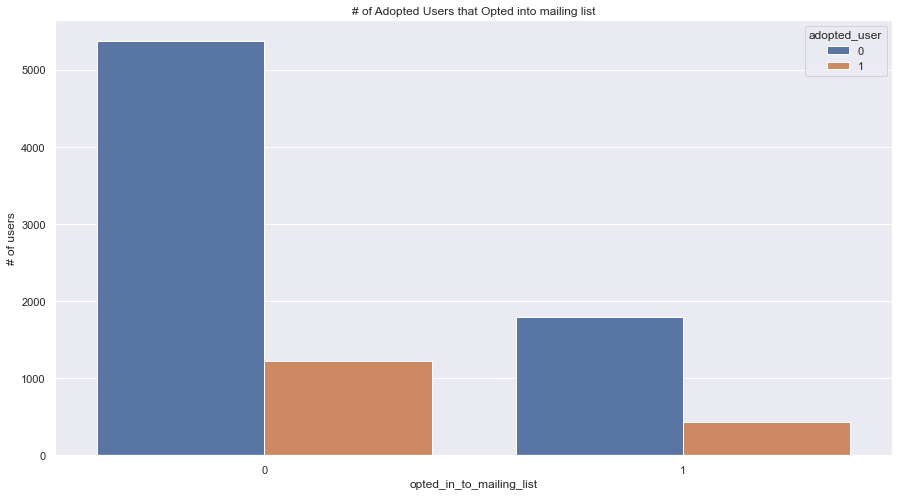

In [250]:
#plot opted into mailing list 
_ = sns.set()
_ = plt.figure(figsize=(15,8))
_ = sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=df_adopted)
_ = plt.title('# of Adopted Users that Opted into mailing list')
_ = plt.ylabel('# of users')
#ax2 = sns.barplot(x='enabled_for_marketing_drip', y=df_adopted.index, hue='adopted_user', data=df_adopted)

For users that opted in to the mailing list, less than 500 of them are adopted_users, for users that opted out of the mailing list, over 1000 are adopted users. However, the ratio between adopted and not adopted users seems to be comparable between users that opted in and out of the mailing list. I do not expect this feature to be incredibly significant. 

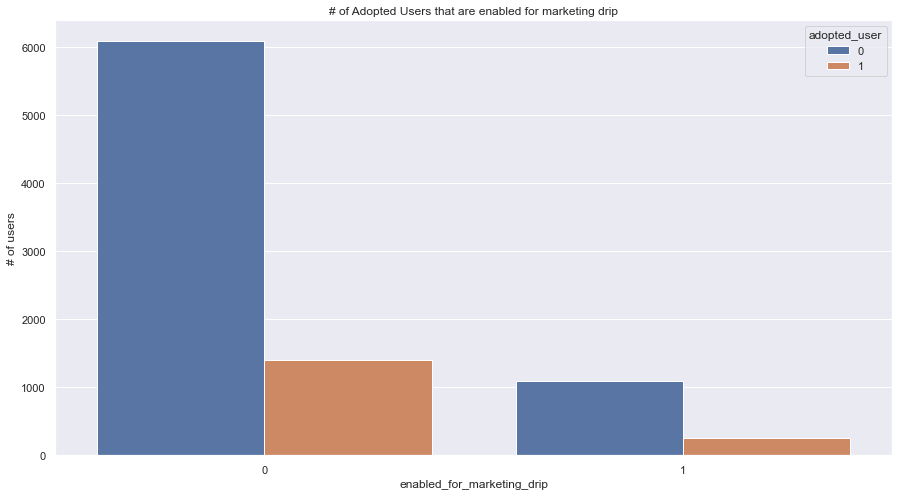

In [251]:
#plot enabled for marketing drip
_ = sns.set()
_ = plt.figure(figsize=(15,8))
_ = sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=df_adopted)
_ = plt.title('# of Adopted Users that are enabled for marketing drip')
_ = plt.ylabel('# of users')

We have a similar story between the two columns. I again, do not expect this variable to be overwhelmingly significant.

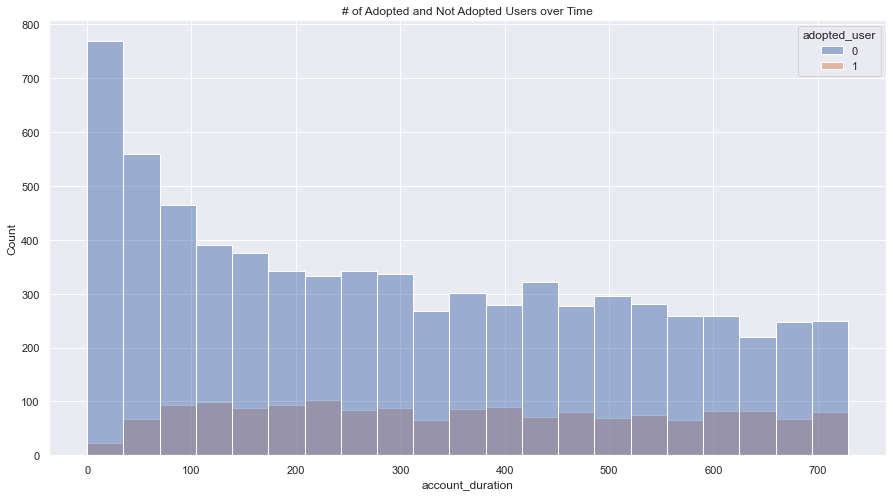

In [261]:
#plot account duration 
_ = sns.set()
_ = pdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA30AAAHwCAYAAAASOwaWAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAABHr0lEQVR4nO3de1iUdf7/8dcwHFS0XGgII7OTpVmJZgdSIdsWUCQMbb9qpWWZtqarbaarpHkojSzNWre2rDZ1t8zDoqxhW66Hwjxg6dpquZ5CMxjPgjLAzP37w19TKCAow9zcPB/X1XU599xzf97zecM0L+6TzTAMQwAAAAAASwrwdwEAAAAAAN8h9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AfOTRRx/Vrl27VFxcrISEhGq99sCBA+revbtSUlL01VdfnfX8t99+q+uvv15/+ctfKt3OxIkT9dprr1Vr7F/asmWLxo0bV+3XXei4lcnKytJDDz101vJ9+/bp+uuv10cffVRm+ezZszV69Ohzbvf111/Xp59+WuHzU6dO1Y033qgff/yx0u20a9dO+/btO+d451tHdccdPXq0Zs+eXeX1raB3795KSUlRt27d1Lp1a6WkpCglJUV/+MMfNHbsWGVnZ/u7RACoVYH+LgAArKi0tFS5ubm6+uqrtX79et18883Vev26det0ySWX6L333iv3+b/97W9KTk7WvHnzNGDAAAUG+ubj/H//+5/y8vJ8sm1fCAgI0IsvvqhbbrlFV199dbVeu27dOl177bXlPudyufSPf/xDCQkJmjt3rp5++umaKLfadaBqPvjgA0mn/xCQnJysjIwMP1cEAP5F6AOAGjZw4EDt2rVLBQUFSklJUV5enkJDQzVv3jw98MADZdb98MMPNWfOHAUEBOiSSy7Rs88+q7y8PM2YMUMnTpzQQw89pDlz5pR5TUFBgZYuXaqPPvpI27dv1/Lly5WUlOR9buzYsdq+fbsiIiJkt9t1yy23SJJ27NihiRMn6ujRo7LZbBowYIB69OihdevWadq0abrsssu0a9cuNWjQQFOnTlWjRo00c+ZMnThxQn/84x81ZcoUrVixQn/+859VUlKiBg0aaNSoUWrXrl2l4/7SwYMHNW7cOB06dEhOp1NRUVGaMWOGwsPDdffdd+u+++7T2rVrdeDAAaWkpGj48OGSpFdffVVLly5V06ZN1aJFiwrnvkGDBnrkkUf09NNP64MPPlBwcHCZ50+cOKEJEyZo+/btstls6ty5s5566il9+OGH2rp1q9LT02W32/Wb3/ymzOv++c9/6oorrtDDDz+sRx99VEOGDFHDhg0lSRs3btSkSZNks9l00003yePxVNrfq666SqNHj1ZISIi2b9+uQ4cOqWPHjkpLS9P8+fPL1BEXF6dp06Zpw4YNcrvduuGGG5SWlqbGjRtXOm51lJaWatKkSdq0aZOCgoJ0+eWXa8qUKQoNDdWmTZs0bdo0nTp1SgEBAXryySfVpUsXLVq0SAsWLNCpU6fUuHFjvfLKKxo1apSOHDkiSYqLi/P27pc2btyo9PR0nTp1SkFBQRo+fLhiY2PVu3dvPfLII9494i+99JIkaeTIkfroo4/097//XR6PR02bNtWzzz6ra665RqNHj9bRo0eVm5uru+66SyNHjqzS+33ooYf0wAMP6MYbb1T//v3VsWNHbd26VW63W8OGDdOHH36oXbt26cYbb9Qrr7yigICACucBAOoMAwBQ4+bNm2e88cYbhmEYxpAhQ4xvvvnmrHWys7ONe+65xzh06JBhGIaxcOFCo2vXrobH4zEWLlxoPP744+Vue+7cucZ9991nGIZhvPXWW0avXr28zz3//PPGM888Y3g8HuPQoUNGbGysMXPmTKOkpMT49a9/bSxfvtwwDMP48ccfjc6dOxubNm0yvvzyS6NVq1bGhg0bDMMwjL/97W/e7f+yjt27dxvdu3c3Dh8+bBiGYXz33XdGx44djcLCwgrHPdN7771nvPnmm4ZhGIbH4zEee+wxY/bs2YZhGEaXLl2MqVOneuu76aabjO+//97417/+ZXTr1s04ceKEUVJSYjz++OPGgw8+eNa2c3NzjejoaMPtdhsPPPCAd1tvv/22MWrUKMMwDOOZZ54xJk2aZHg8HsPlchkDBgzw1vPggw8aH3/8cblz3rNnT2POnDmGYRhGt27djHnz5hmGYRgul8u48847jezsbMMwDGPp0qXGddddZ+Tm5lba31GjRhk9evQwCgoKDJfLZTzwwAPe7f+yjtdee82YOnWq4fF4DMMwjJdfftkYP358peOeadSoUcbbb7991vLo6GgjNzfX2LBhg5GYmOgdIz093cjJyTGOHj1qxMfHe7f5448/GrGxscb+/fuNhQsXGrfeeqtx4sQJwzAM4/XXXzeeffZZwzAMo7Cw0Bg+fLhx/PjxMuMdPnzYiImJMb7++mvDME7//Nx2223G999/byxYsMD7c1ZaWmp06tTJ2L17t7Fu3Tqjb9++xsmTJw3DMIw1a9YYiYmJ3vfVv3//cvv1k59+Jn7pp/nNzc01rrvuOuPTTz81DMMwxo0bZ3Tp0sU4ceKEUVRUZHTs2PGc8wAAdQXn9AGAD2zfvl2tW7eWdHoPW3mH661Zs0bdunVTWFiYJCk1NVV5eXnnPM/qgw8+0H333SdJuvfee/XNN994z/tbu3atevToIZvNprCwMO8eqz179sjlcik+Pl6SdOmllyo+Pl5r1qyRJLVq1UodOnSQJPXs2VPbtm3z7rX5yRdffKH8/Hw9/PDDSklJ0dNPPy2bzabvv/++wnHP1L9/f7Vv317vvvuunnvuOe3YsUMnT570Pv/rX//aW194eLiOHTumtWvX6je/+Y0aN26swMBA9ezZs9L5CQgI0EsvvaRFixbpiy++KPPc6tWr9eCDD8pmsyk4OFi9e/fW6tWrK93eN998o+3bt3v3pvbo0UPvv/++DMPQd999p8DAQMXExEiSunfvrtDQUEnn7u99992n0NBQBQcHKyUlRZ9//vlZY69cuVIrVqxQjx49lJKSok8//VQ7d+6sdNwz2Wy2cpd7PB7Z7XZdd911stvtuv/++zVjxgwlJCSoffv2+vrrr+V0OjVkyBClpKTo8ccfl81m07fffitJuv7669W4cWNJUufOnfXJJ59o4MCB+vDDD/WHP/xBTZo0KTPeli1bdMUVV6ht27aSpJYtW6p9+/Zav369unXr5h3v888/15VXXqkrr7xSK1eu1N69e73n6L300ks6fvy4jh49Kknl7k2ujqCgIN19992SpCuuuELt2rVT48aNFRISooiICB07duyc8wAAdQGHdwJADRs4cKDWr1+vTZs2KT09XXl5ebr//vv129/+tszhneUdjmcYhkpLSyvc9saNG7Vjxw69/fbbevfddyWd/uL63nvvqV27dt5t/MRut0uS3G73WV/+fznWT+v90pnLPB6PYmJiNGPGDO+yAwcOKCIiosJxz/TSSy9py5Yt6tmzp26//XaVlpaWeV1ISIj33zabzftcVbb9S82aNdOECRM0atQo9ejRo8x7+OU8eDyeSudbkubNm1cmbJaWlio/P1+rV69WeHh4mdokec+vPFd/f/k+DMNQQMDZf4f1eDwaM2aM4uLiJEmFhYVyuVz64YcfKhz3TL/61a+8IeknBQUFcrlcuuiiixQaGqqMjAxt2rRJX375pYYPH65HH31UzZo10zXXXFPmwjh5eXkKCwvT0qVL1ahRI+/ym2++WZ999pnWrl2rL7/8Uvfff7/eeust3Xjjjd51KvsZbNiwoRISEpSZmamvvvpK999/v/f9p6SkeA/d9Hg8ys/P18UXXyxJZWo4H0FBQWVqCgoKOmsdt9td4TwAQF3Bnj4AqGEzZsxQVFSUMjMzNXz4cPXq1UsZGRlnnc/XuXNnLVu2TIcPH5YkLVy48JznrP39739XSkqKVq1apRUrVmjFihV644039K9//Us//PCDOnfurAULFsjj8ejYsWP67LPPJElXX321AgMD9cknn0g6/aV1+fLluvPOOyWd3jO5fft2SafPQ2vXrp0uuugi2e12b0iJiYnRF198oZ07d0qSVq1apXvvvVdFRUUVjnumzz//XP3791ePHj0UHh6u7Oxsud3uSuczNjZWWVlZOn78uDweT5UvypGYmKjY2Fj99a9/9S7r1KmT5s6dK8MwVFxcrPnz53vn4Jfv9SfHjx/XsmXL9MYbb3jne/Xq1br33nv117/+Vddff70Mw9CqVaskSZ999pmOHTsm6dz9/fjjj1VcXCyXy6XFixd7zxH7ZR2dOnXSvHnzVFxcLI/Ho2effVavvPJKpeOWN38ff/yx94I8hmHor3/9q2699VaFhobq3//+tx5++GG1a9dOQ4cOVY8ePbR161ZFR0dr79692rBhgyRp27ZtSkhIKPfCPtOmTdOsWbN0zz33aOzYsbr22mu1Y8eOMutER0dr165d2rJli6TTe8A3bNig2267TZL029/+VosXL9amTZu85/Z16tRJ//znP5Wfny/p9M9///79K+y5L1RnHgDArNjTBwA17Ouvv1b79u0lnd4zd+utt5a7XseOHfXwww+rf//+8ng8CgsL05tvvlnuHh9JOnz4sD755BMtXLiwzPKYmBhFR0drzpw5GjZsmMaPH6+uXbsqLCxM1113naTTezBmzZqlyZMn67XXXpPb7daQIUN0xx13eK8UOmPGDO3fv19hYWFKT0+XdPoL75/+9Cc9+eSTev311zVx4kQ99dRTMgxDgYGB+vOf/6zQ0FANHTq03HHPNGTIEKWnp+vVV19VUFCQ2rdvr++//77S+YyLi9O3336rnj176qKLLlKrVq3OOvS0ImlpacrJySnzePLkyUpOTlZJSYk6d+6swYMHS5LuvvtuvfLKKyopKfEePrt48WJdc801uuOOO8ps94knnlBSUpJ2796tP/3pT3ruuef0yiuvqHXr1goPD5d07v42aNBAffv21fHjx5WQkODdk/jLOn73u9/pxRdf1H333Se3263WrVtr9OjRCgoKqnDcM91xxx0aOHCgHn/8cUlSUVGRbrjhBr388suSTofC1atXq3v37mrUqJEuvvhiTZo0SWFhYZo5c6bS09PlcrlkGIbS09N1+eWXa/369WXG6N+/v0aPHq3u3bsrODhY119/vfdw2J+EhYXp1Vdf1aRJk1RUVCSbzaYpU6boqquukiTdeOONstvtSkxM9O7x7dSpkwYOHKgBAwbIZrOpcePGev311ys8ZNUXKpsHAKgrbMaZx4cAAOqVdevWadKkScrMzPR3KfXG6NGj1bJlSz366KP+LgUAUA9weCcAAAAAWBh7+gAAAADAwtjTBwAAAAAWRugDAAAAAAsj9AEAAACAhfn0lg0ZGRn6y1/+Iun0JaFHjRql7OxsTZkyRS6XS127dtWIESMknb7vzdixY1VYWKgOHTpowoQJFd5otjxHjhTK4zHX6Ynh4Y116FCBv8tABeiP+dEjc6M/5kePzI3+mBv9MT969LOAAJt+9avQCp/3Weg7deqUnn/+eWVlZemiiy5Snz59tGLFCk2cOFFz5sxRs2bNNGjQIK1atUpxcXEaOXKkJk+erOjoaI0ZM0bz589X3759qzyex2OYLvRJMmVN+Bn9MT96ZG70x/zokbnRH3OjP+ZHj6rGZ4d3ut1ueTwenTp1SqWlpSotLVXjxo3VokULNW/eXIGBgUpOTlZWVpb279+voqIiRUdHS5JSU1OVlZXlq9IAAAAAoN7w2Z6+xo0b6/e//726du2qhg0b6tZbb1V+fr4cDod3nYiICOXl5Z213OFwKC8vr1rjhYc3rrHaa5LD0cTfJaAS9Mf86JG50R/zo0fmRn/Mjf6YHz2qGp+Fvu3bt2vhwoX697//rSZNmujpp5/Wnj17ZLPZvOsYhiGbzSaPx1Pu8uo4dKjAdLt3HY4mcjpP+LsMVID+mB89Mjf6Y370yNzoj7nRH/OjRz8LCLBVuhPMZ6Hv888/V0xMjMLDwyWdPmRz9uzZstvt3nWcTqciIiIUGRkpp9PpXX7w4EFFRET4qjQAAAAAtcwwDBUUHNOpUwXyeNwXvL38/AB5PJ4aqKzuCAiwq2HDxmrc+OJq7STzWehr1aqVXnrpJZ08eVINGzbUihUr1LZtWy1dulR79+7V5ZdfrszMTPXs2VNRUVEKCQlRTk6ObrnlFmVkZCg2NtZXpQEAAACoZUeOOGWz2RQWdqns9sBqH9l3psDAAJWW1p/QZxiG3O5SnThxVEeOOBUWVvWdZD4LfZ06ddJ///tfpaamKigoSDfddJOGDh2qjh07aujQoXK5XIqLi1NiYqIkadq0aUpLS1NBQYHatGmjfv36+ao0AAAAALWsuLhIl156uWw2bhV+Pmw2mwIDg9S0abjy8vZV77WGYZjrRLjzxDl9qC76Y370yNzoj/nRI3OjP+ZGf2rejz/uVWRkixrbXn3b0/dLZ87luc7pI2YDAAAAgIUR+gAAAACY2jPPDNeyZUvP+/XZ2Z/r7bffqPVxzYLQBwAAAMDStm37RsePH/N3GX7jswu5AAAAAEBlPB6PZs58Rd988x+dOnVShmFo1Kg0XXZZlCZPHq+DBw8qMjJSR44c8b5m8+av9Kc/vSqXq0iBgUEaOPAJ3XHHnVq2bKn+/e9P5fEYyss7oEsucSgtbYLy8vKUkbFIHo9boaGNNWjQEGVm/kOLFi2QYXh00UVN9dRTz6hFiyt18KCzwnErsmzZUq1c+ZnS02ec9Xjz5q/1+uuvyO0+fV/yhx56WHfd9WuVlJToz3+eqa+/3iS326Prrrtew4c/rdDQxurVK1k33HCjdu7coccfH6K4uC4XPM+EPgAAAAB+8d//btXBg069+ea7CggI0Jw572nu3L/KbrerTZubNHDgE9q3L1ePPNJXknTs2FGlpY3S1KmvqG3bm/Xddzs0dOjjeuut9yVJX3+9SbNnz9UVV7TQn//8mmbMeEmTJ6crJSVVx44d1aBBQ/TVVzn6+ON/atast9WgQQOtX/+lxox5WvPmLdDLL79Y7rjn65133tT//d8DuueeBP3vfzuUkbFId931a82d+57s9kDNnj1XNptNb775J/35z6/r6adHS5KuvvoaTZw45cIm9xcIfQAAAAD84sYbb9bjj1+kjIxF2r9/n776KkeNGjXS9u3b9OSTwyVJl1/eXO3bd5B0OiRefvnlatPmRkmnw9FNN7XVV1/lyGaz6dZb79AVV5y+quW9996nhx8+O7StXfu59u3L1eDBA7zLTpw4oePHj2njxvXljnu+unS5R6+8kq4vvlijDh1u06BBQyRJ2dlrdOJEgTZsWCdJKi0tUdOmv/K+7uaboy9o3DMR+gAAAAD4RXb253r11Wnq3ftBde4cpxYtrtTy5ctks9n0yzvL2e2nY4vb7ZFU9qbuHo+h0tJSBQUFyW63/2K5R3b72Zcwcbs9Skjopt/9bph3vYMHnWrS5KIKx63Mma8pKSnx/rtHj57q1ClW69d/qXXrsvXOO3/R3/62UG63R7///R8UE9NRknTy5EkVFxd7X9eoUaNzjlsdXMgFAAAAgF9s2LBOHTt21n339VKrVq21Zs1KeTwe3X57jJYsWSRJ+vHHH7Vp00ZJp/cMfv/9Hv33v1slSbt27dTmzZvUrt0tkqScnA1yOvMlSf/4x0J17NhZkmS321VaWipJuv32GH366XIdPHjQu97vf/+E97nyxq1M06ZNtWvXTrlcLpWWlmrlys+8zw0ePEDfffetunVL1jPPjFVBwQkdPnxIt98eo0WL5qukpEQej0cvvjhZb775+oVMZaXY0wcAAADAL3r06Knnnhujfv3+T263W7feeodWrVqhyZNf1NSpk/TAA73kcESoZcvrJJ0OWJMmvajp019ScbFLkk1jxozXFVe00NatW+RwRGjSpHE6dOigrrzyKj3zzFhJ0i233KoJE9I0fXq6Rox4Rg880F8jRvxOAQEBatQoVM8//5JsNpueemqUpkyZcNa4lbn11jsUHd1eDzzQS+Hhl6h9+w7auXOHJOmJJ4bp1Ven6a23Zslms+mRRwaqWbPL9PDDj+r111/VI488II/HrZYtr/MeVuoLNuOX+yLrsEOHCuTxmOutOBxN5HSe8HcZqAD9MT96ZG70x/zokbnRH3OjPzXvxx/3KjKyRY1tLzAwQKWlHu/jM6+iaWVnzmVAgE3h4Y0rXJ89fQAAAABQid/97jGdPHmy3OdmzXpLjRqF1nJF1UPo8yG32yOHo4m/y/AqLnHr2NHyf1gBAACAuqxbt2R165bsk23PmvW2T7ZbWwh9PmS3B+itRZv9XYbXwNS2/i4BAAAAQC3j6p0AAAAAYGGEPgAAAACwMEIfAAAAAFgY5/QBAAAAqNMubtpIwUH2Gt+uVS6ESOgDAAAAUKcFB9l9cgHFql4I8ZNPsvT++7NVWlqq++/vo549f1vjtVwIQh8AAAAAnCenM19vvTVLs2fPUVBQsAYPHqD27Tvoqquu9ndpXpzTBwAAAADnaePG9WrfvoMuuuhiNWzYUF26/ForV37m77LKIPQBAAAAwHk6eNCp8PBLvI/Dwy9Rfn6+Hys6G6EPAAAAAM6Tx+ORzWbzPjYMQwEBtkpeUfsIfQAAAABwniIiLtWhQwe9jw8fPqRLLnH4saKzEfoAAAAA4Dx16HCbcnI26MiRIyoqKtLKlSt0++0x/i6rDK7eCQAAAKBOKy5xV/n2CtXd7rk4HBEaOPB3GjZskEpKSpWcnKIbbrixxmu5EIQ+AAAAAHWav2+gHh+fqPj4RL/WUBkO7wQAAAAACyP0AQAAAICFEfoAAAAAwMIIfQAAAABgYYQ+AAAAALAwQh8AAAAAWBi3bAAAAABQp4U1bSB7UFCNb9ddUqLDR4uqtG5hYYEGDx6g9PQZatbsshqv5UIQ+gAAAADUafagIO37+P0a3+7lXftJOnfo++abrUpPn6zc3O9rvIaawOGdAAAAAHABli5drKeeGqVLLnH4u5RysacPAAAAAC7A6NHP+ruESrGnDwAAAAAsjNAHAAAAABZG6AMAAAAAC+OcPgAAAAB1mruk5P9fabPmt2sFhD4AAAAAddrpe+lV7X56vrRgwVJ/l1AuDu8EAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAaoFNhuHxdxF13uk5tFXrNT67kMtHH32kuXPneh/v27dPKSkpuueeezRlyhS5XC517dpVI0aMkCRt27ZNY8eOVWFhoTp06KAJEyYoMJDrzAAAAABWEBzcQEePHlSTJr+S3R4om616waW+MwxDbnepTpw4ouDgBtV6rc9S1f3336/7779fkrRjxw4NGTJEAwcOVJ8+fTRnzhw1a9ZMgwYN0qpVqxQXF6eRI0dq8uTJio6O1pgxYzR//nz17dvXV+UBAAAAqEW/+pVDBQXHdPhwnjwe9wVvLyAgQB5P/dpzGBBgV8OGjdW48cXVel2t7Ep77rnnNGLECOXm5qpFixZq3ry5JCk5OVlZWVm69tprVVRUpOjoaElSamqqZs6cSegDAAAALMJms6lJk6Zq0qRpjWzP4Wgip/NEjWzL6nwe+rKzs1VUVKSuXbsqMzNTDofD+1xERITy8vKUn59fZrnD4VBeXl61xgkPb1xjNdek0NAQf5dQhsPRxN8lmArzYX70yNzoj/nRI3OjP+ZGf8yPHlWNz0PfBx98oEceeUSS5PF4yhy7axiGbDZbhcur49ChAnk8Rs0UXUMcjiYqLHT5u4wy+GvIz/jrkPnRI3OjP+ZHj8yN/pgb/TE/evSzgABbpTvBfHr1zuLiYm3YsEF33323JCkyMlJOp9P7vNPpVERExFnLDx48qIiICF+WBgAAAAD1gk9D37fffqsrr7xSjRo1kiS1bdtWu3fv1t69e+V2u5WZmanY2FhFRUUpJCREOTk5kqSMjAzFxsb6sjQAAAAAqBd8enhnbm6uIiMjvY9DQkI0depUDR06VC6XS3FxcUpMTJQkTZs2TWlpaSooKFCbNm3Ur18/X5YGAAAAAPWCT0Nft27d1K1btzLLYmJitGTJkrPWbdWqlRYsWODLcgAAAACg3vHp4Z0AAAAAAP8i9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMJ+GvhUrVig1NVVdu3bV5MmTJUnZ2dlKTk5WfHy8pk+f7l1327ZtSk1NVUJCgsaOHavS0lJflgYAAAAA9YLPQl9ubq7Gjx+vWbNmacmSJfrvf/+rVatWacyYMZo1a5aWLVumrVu3atWqVZKkkSNHaty4cVq+fLkMw9D8+fN9VRoAAAAA1Bs+C33/+te/1K1bN0VGRiooKEjTp09Xw4YN1aJFCzVv3lyBgYFKTk5WVlaW9u/fr6KiIkVHR0uSUlNTlZWV5avSAAAAAKDeCPTVhvfu3augoCANHjxYBw4c0F133aWWLVvK4XB414mIiFBeXp7y8/PLLHc4HMrLy6vWeOHhjWus9poUGhri7xLKcDia+LsEU2E+zI8emRv9MT96ZG70x9zoj/nRo6rxWehzu93auHGj5syZo0aNGumJJ55QgwYNZLPZvOsYhiGbzSaPx1Pu8uo4dKhAHo9RY/XXBIejiQoLXf4uowyn84S/SzANh6MJ82Fy9Mjc6I/50SNzoz/mRn/Mjx79LCDAVulOMJ+FvksuuUQxMTEKCwuTJN1zzz3KysqS3W73ruN0OhUREaHIyEg5nU7v8oMHDyoiIsJXpQEAAABAveGzc/q6dOmizz//XMePH5fb7daaNWuUmJio3bt3a+/evXK73crMzFRsbKyioqIUEhKinJwcSVJGRoZiY2N9VRoAAAAA1Bs+29PXtm1bPfbYY+rbt69KSkrUsWNH9enTR1dffbWGDh0ql8uluLg4JSYmSpKmTZumtLQ0FRQUqE2bNurXr5+vSgMAAACAesNnoU+SevXqpV69epVZFhMToyVLlpy1bqtWrbRgwQJflgMAAAAA9Y5Pb84OAAAAAPAvQh8AAAAAWBihDwAAAAAsjNAHAAAAABZG6AMAAAAACyP0AQAAAICFEfoAAAAAwMIIfQAAAABgYYQ+AAAAALAwQh8AAAAAWBihDwAAAAAsjNAHAAAAABZG6AMAAAAACyP0AQAAAICFEfoAAAAAwMIIfQAAAABgYYH+LgC1x+32yOFo4u8yyigucevY0ZP+LgMAAACwLEJfPWK3B+itRZv9XUYZA1Pb+rsEAAAAwNI4vBMAAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsL9OXGH3roIR0+fFiBgaeHmThxogoLCzVlyhS5XC517dpVI0aMkCRt27ZNY8eOVWFhoTp06KAJEyZ4XwcAAAAAOD8+S1WGYWjPnj3697//7Q1vRUVFSkxM1Jw5c9SsWTMNGjRIq1atUlxcnEaOHKnJkycrOjpaY8aM0fz589W3b19flQcAAAAA9YLPDu/ctWuXJGnAgAG69957NXfuXG3ZskUtWrRQ8+bNFRgYqOTkZGVlZWn//v0qKipSdHS0JCk1NVVZWVm+Kg0AAAAA6g2f7ek7fvy4YmJi9Oyzz6qkpET9+vXTY489JofD4V0nIiJCeXl5ys/PL7Pc4XAoLy+vWuOFhzeusdprUmhoiL9LKMNs9UiSw9GkXo6NqqFH5kZ/zI8emRv9MTf6Y370qGp8FvratWundu3aeR/36tVLM2fO1C233OJdZhiGbDabPB6PbDbbWcur49ChAnk8xoUXXoMcjiYqLHT5u4wyzFaPJDmdJ/wyrsPRxG9jo2rokbnRH/OjR+ZGf8yN/pgfPfpZQICt0p1gPju8c+PGjVq7dq33sWEYioqKktPp9C5zOp2KiIhQZGRkmeUHDx5URESEr0oDAAAAgHrDZ6HvxIkTSk9Pl8vlUkFBgRYvXqynnnpKu3fv1t69e+V2u5WZmanY2FhFRUUpJCREOTk5kqSMjAzFxsb6qjQAAAAAqDd8dnhnly5dtHnzZvXo0UMej0d9+/ZVu3btNHXqVA0dOlQul0txcXFKTEyUJE2bNk1paWkqKChQmzZt1K9fP1+VBgAAAAD1hk9vhDd8+HANHz68zLKYmBgtWbLkrHVbtWqlBQsW+LIcAAAAAKh3fHZ4JwAAAADA/wh9AAAAAGBhhD4AAAAAsDBCHwAAAABYGKEPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIUR+gAAAADAwgh9AAAAAGBhhD4AAAAAsDBCHwAAAABYGKEPAAAAACws0N8FoH5zuz1yOJr4bfwzxy4ucevY0ZN+qgYAAACoeYQ++JXdHqC3Fm32y9ihoSEqLHSVWTYwta1fagEAAAB8hcM7AQAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGFVCn1jxow5a9mwYcNqvBgAAAAAQM0KrOzJ8ePHKy8vTzk5OTp8+LB3eWlpqXJzc31eHAAAAADgwlQa+nr16qUdO3bo22+/VUJCgne53W5XdHS0r2sDAAAAAFygSkPfTTfdpJtuukl33nmnIiMja6smAAAAAEANqTT0/eTAgQMaOXKkjh07JsMwvMuXLl3qs8IAAAAAABeuSqFv3LhxSk1N1Q033CCbzebrmgAAAAAANaRKoS8wMFCPPPKIr2sBAAAAANSwKt2yoWXLlvr22299XQsAAAAAoIZVaU9fbm6uevbsqcsuu0whISHe5ZzTBwAAAADmVqXQN2LECF/XAQAAAADwgSqFvuuuu87XdQAAAAAAfKBKoe+OO+6QzWaTYRjeq3c6HA6tXr3ap8UBAAAAAC5MlULf9u3bvf8uLi5WZmamdu/eXaUBXnzxRR05ckRTp05Vdna2pkyZIpfLpa5du3oPG922bZvGjh2rwsJCdejQQRMmTFBgYJVKAwAAAABUokpX7/yl4OBgpaam6osvvjjnumvXrtXixYslSUVFRRozZoxmzZqlZcuWaevWrVq1apUkaeTIkRo3bpyWL18uwzA0f/786pYFAAAAAChHlULf0aNHvf8dOXJEa9as0fHjx8/5munTp2vw4MGSpC1btqhFixZq3ry5AgMDlZycrKysLO3fv19FRUWKjo6WJKWmpiorK+vC3hUAAAAAQNJ5nNMnSeHh4Ro7dmylrxk3bpxGjBihAwcOSJLy8/PlcDi8z0dERCgvL++s5Q6HQ3l5edV+I+Hhjav9mtoQGhpy7pVqkdnqkfxbU3ljOxxN/FAJKkI/zI3+mB89Mjf6Y270x/zoUdVU+5y+qvjoo4/UrFkzxcTEaNGiRZIkj8fjvQiMJO9FYSpaXl2HDhXI4zGq/TpfcjiaqLDQ5e8yyjBbPZL/agoNDSl3bKfzhB+qQXkcjib0w8Toj/nRI3OjP+ZGf8yPHv0sIMBW6U6wKoU+j8ej2bNna/Xq1SotLVXHjh01ePDgCi+2smzZMjmdTqWkpOjYsWM6efKk9u/fL7vd7l3H6XQqIiJCkZGRcjqd3uUHDx5UREREVd8fAAAAAKASVTqn7+WXX9aXX36p/v3765FHHtFXX32l9PT0Ctd/9913lZmZqYyMDA0bNkx333233n77be3evVt79+6V2+1WZmamYmNjFRUVpZCQEOXk5EiSMjIyFBsbWzPvDgAAAADquSrt6VuzZo0WLlyooKAgSdJdd92le++9V2PGjKnyQCEhIZo6daqGDh0ql8uluLg4JSYmSpKmTZumtLQ0FRQUqE2bNurXr995vBUAAAAAwJmqFPoMw/AGPun0bRt++bgyqampSk1NlSTFxMRoyZIlZ63TqlUrLViwoErbA3zJ7faY6oTg4hK3jh096e8yAAAAUIdVKfS1atVKL7zwgh588EHZbDbNmTNH1113na9rA2qd3R6gtxZt9ncZXgNT2/q7BAAAANRxVTqnb/z48Tp+/Lh69+6t+++/X0eOHNGzzz7r69oAAAAAABeo0tBXXFysUaNGae3atZo6daqys7N18803y263q3Fjc94XDwAAAADws0pD38yZM1VQUKD27dt7l02aNEnHjx/Xa6+95vPiAAAAAAAXptLQt3LlSr388ssKDw/3Lrv00kuVnp6uTz/91OfFAQAAAAAuTKWhLygoSA0aNDhreePGjRUcHOyzogAAAAAANaPS0BcQEKCCgoKzlhcUFKi0tNRnRQEAAAAAakalt2zo3r270tLS9MILL6hRo0aSpJMnTyotLU3x8fG1UiBQn3HfQAAAAFyoSkNf//79NX78eHXs2FEtW7aUx+PRzp07lZycrCFDhtRWjUC9xX0DAQAAcKEqDX0BAQGaNGmSBg8erG+++UYBAQG6+eabFRERUVv1AQAAAAAuQKWh7ydRUVGKiorydS0AAAAAgBpW6YVcAAAAAAB1G6EPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIUR+gAAAADAwgh9AAAAAGBhhD4AAAAAsDBCHwAAAABYGKEPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIUR+gAAAADAwgL9XQCAusPt9sjhaFKrY55rvOISt44dPVlL1ZzbxU0bKTjI7u8yvMw2PwAAoPYR+gBUmd0eoLcWba618UJDQ1RY6Kp0nYGpbWupmqoJDrLX6hydi9nmBwAA1D4O7wQAAAAAC2NPHwBYmK8Pya3utjncFACA2kfoAwAL8+UhuVU5/PZMHG4KAEDtI/QBqNP8cXEZAACAuoTQB6BOq+2Ly5wLe7IAAIDZcCEXAAAAALAwQh8AAAAAWBihDwAAAAAsjNAHAAAAABbGhVwAAECFLm7aSMFBdn+X4cW9HgGg+gh9AACgQsFBdq6QCwB1HId3AgAAAICFEfoAAAAAwMIIfQAAAABgYYQ+AAAAALAwQh8AAAAAWBihDwAAAAAsjNAHAAAAABbm09D36quvqlu3bkpKStK7774rScrOzlZycrLi4+M1ffp077rbtm1TamqqEhISNHbsWJWWlvqyNAAAAACoF3wW+tavX68vv/xSS5Ys0cKFCzVnzhxt375dY8aM0axZs7Rs2TJt3bpVq1atkiSNHDlS48aN0/Lly2UYhubPn++r0gAAAACg3gj01YZvu+02vf/++woMDFReXp7cbreOHz+uFi1aqHnz5pKk5ORkZWVl6dprr1VRUZGio6MlSampqZo5c6b69u3rq/IAANDFTRspOMju7zLKKC5x69jRk/4uAwBgIT4LfZIUFBSkmTNn6p133lFiYqLy8/PlcDi8z0dERCgvL++s5Q6HQ3l5edUaKzy8cY3VXZNCQ0P8XUIZZqtH8m9N5Y1ttjmq7/VUZbz6Pkfn4st6zmfbDkcTH1Ry/v62fLu/Syijb0KrGp2jmtiW2X6mzfYzdCGs9F6siP6YHz2qGp+GPkkaNmyYBg4cqMGDB2vPnj2y2Wze5wzDkM1mk8fjKXd5dRw6VCCPx6ixumuCw9FEhYUuf5dRhtnqkfxXU2hoSLljm22O6nM9FfXoTPV5jqrCV/VUtT9ncjpP+KCa82PGz2mp5ubI4Whywdsy4xyZ6WfoQtREf+A79Mf86NHPAgJsle4E81no27lzp4qLi9W6dWs1bNhQ8fHxysrKkt3+82E0TqdTERERioyMlNPp9C4/ePCgIiIifFUaAABAjbjQQ4R9sZeCQ4QBnMlnoW/fvn2aOXOm/v73v0uSPvvsM/Xu3Vvp6enau3evLr/8cmVmZqpnz56KiopSSEiIcnJydMsttygjI0OxsbG+Kg0AAKBGBAfZ9daizef12vPdW34uA1Pb1vg2AdRtPgt9cXFx2rJli3r06CG73a74+HglJSUpLCxMQ4cOlcvlUlxcnBITEyVJ06ZNU1pamgoKCtSmTRv169fPV6UBAAAAQL3h03P6hg4dqqFDh5ZZFhMToyVLlpy1bqtWrbRgwQJflgMAAAAA9Y5Pb84OAAAAAPAvQh8AAAAAWBihDwAAAAAsjNAHAAAAABbm85uzAwAAoPa43R6f3P/vfHHfQMD/CH0AAJhITX9hN9OXf9QOuz3gvO8d6AvcNxDwP0IfAAAmUpNf2Gvi5t9m+8Jutr1YAFAXEPoAAECdwV4sAKg+LuQCAAAAABZG6AMAAAAACyP0AQAAAICFcU4fAKDWcBEOAABqH6EPAFBruAgHAAC1j8M7AQAAAMDCCH0AAAAAYGGEPgAAAACwMM7pAwAAgM+Y7QJOpW6PAu1V2+9RG3UXl7h17OhJn4+D+o3QBwAAAJ8x4wWcqlJPaGiICgtdtVIP4Gsc3gkAAAAAFkboAwAAAAALI/QBAAAAgIVxTh8AAAAA07q4aSMFB9nLfc4fFwmqixffIfQBAAAA8KosZPlLeRffqa2L7ZypLl58h9AHAAAAwCs4yG66K67iwnBOHwAAAABYGKEPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIUR+gAAAADAwgh9AAAAAGBhhD4AAAAAsDBCHwAAAABYGKEPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIUF+rsAAAAAoL5yuz1yOJr4uwxYHKEPAAAA8BO7PUBvLdrs7zLKGJja1t8loIZxeCcAAAAAWBihDwAAAAAsjNAHAAAAABZG6AMAAAAACyP0AQAAAICF+TT0vf7660pKSlJSUpLS09MlSdnZ2UpOTlZ8fLymT5/uXXfbtm1KTU1VQkKCxo4dq9LSUl+WBgAAAAD1gs9CX3Z2tj7//HMtXrxY//jHP/TNN98oMzNTY8aM0axZs7Rs2TJt3bpVq1atkiSNHDlS48aN0/Lly2UYhubPn++r0gAAAACg3vBZ6HM4HBo9erSCg4MVFBSka665Rnv27FGLFi3UvHlzBQYGKjk5WVlZWdq/f7+KiooUHR0tSUpNTVVWVpavSgMAAACAesNnoa9ly5beELdnzx59/PHHstlscjgc3nUiIiKUl5en/Pz8MssdDofy8vJ8VRoAAAAA1BuBvh5gx44dGjRokJ555hnZ7Xbt2bPH+5xhGLLZbPJ4PLLZbGctr47w8MY1VXKNCg0N8XcJZZitHsm/NZU3ttnmqL7XU5Xx6vscnYsv6zmfbden+TlfNVlTTWzLbHNkpXp89V6sNEe+UNV6aqtus82PZL6aKqrHX3U6HE38Mu758mnoy8nJ0bBhwzRmzBglJSVp/fr1cjqd3uedTqciIiIUGRlZZvnBgwcVERFRrbEOHSqQx2PUWO01weFoosJCl7/LKMNs9Uj+qyk0NKTcsc02R/W5nop6dKb6PEdV4at6qtqfM9WX+bkQNVXT+fboTGabI6vUU1P9KY9V5shXqlKPL/tzJrPNj2S+msqrpzZ7dCan84Rfxq1IQICt0p1gPju888CBAxoyZIimTZumpKQkSVLbtm21e/du7d27V263W5mZmYqNjVVUVJRCQkKUk5MjScrIyFBsbKyvSgMAAACAesNne/pmz54tl8ulqVOnepf17t1bU6dO1dChQ+VyuRQXF6fExERJ0rRp05SWlqaCggK1adNG/fr181VpAAAAAFBv+Cz0paWlKS0trdznlixZctayVq1aacGCBb4qBwAAAADqJZ/enB0AAAAA4F+EPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAW5tPQV1BQoO7du2vfvn2SpOzsbCUnJys+Pl7Tp0/3rrdt2zalpqYqISFBY8eOVWlpqS/LAgAAAIB6w2ehb/PmzerTp4/27NkjSSoqKtKYMWM0a9YsLVu2TFu3btWqVaskSSNHjtS4ceO0fPlyGYah+fPn+6osAAAAAKhXAn214fnz52v8+PF65plnJElbtmxRixYt1Lx5c0lScnKysrKydO2116qoqEjR0dGSpNTUVM2cOVN9+/b1VWkALCY0NMTfJQAAAJiWz0Lf888/X+Zxfn6+HA6H93FERITy8vLOWu5wOJSXl1ft8cLDG59/sT5kti+jZqtH8m9N5Y1ttjmq7/VUZbxTe7+phUqqqlW96tn5bLs+zc/5qsmaamJbZpsjK9Xjq/dipTnyharWU1t1m21+JPPVVFE9/qrT4Wjil3HPl89C35k8Ho9sNpv3sWEYstlsFS6vrkOHCuTxGDVSa01xOJqosNDl7zLKMFs9kv9qCg0NMeV8nMlsNdZmPVXtUUmxuc4Dri89O9/fofoyPxeipmqqqc85s82RVerx5f+HrDJHvlKVemrze4LZ5kcyX03l1ePP73JO5wm/jFuRgABbpTvBai30RUZGyul0eh87nU5FRESctfzgwYOKiIiorbKAsxzfsdnfJfwsoZW/KwAAAEAdV2u3bGjbtq12796tvXv3yu12KzMzU7GxsYqKilJISIhycnIkSRkZGYqNja2tsgAAAADA0mptT19ISIimTp2qoUOHyuVyKS4uTomJiZKkadOmKS0tTQUFBWrTpo369etXW2XBBMx2Th8qZ8Zz+gAAAFAxn4e+FStWeP8dExOjJUuWnLVOq1attGDBAl+XApPy1+GUQcGBZ58LxuGU51Sb/Sq3R2eiZwAAAJWqtT19AACgasx29U4AQN1G6ANMji9suFBmu2UDzq2m9qhXaW/5ubA3HQDqPEIfYHJcTRQXylc/Q+cVKEz4M0RwBQBYHaEPAGoYIaJuMdUfViRTBmMAQN1G6AOAGmaqEEGAAICzVPWPc7X1Rzz+WAhfI/QBAIA6hS/IuFBV+eNcjZwTWxUJrcz1x0LJlH8wrOj3ns+DqiH0AQCAOsVUX5BN+OUYsKLyfu9rLZifqQ7+3gf4uwAAAAAAgO+wpw8AAMBiOOQNwC8R+gAAACyGQ2AB/BKhDwAAVIq9RgBQtxH6AABApdhrVLkLCcUEagC1gdBXz/A/FwAAatb5hmKfXXnQhMEYdQ/fGa2F0FfPmOqvtRL/YwLqIb5IAPUPv/d1j6m+M/J98YIR+gAAtYovEkD9w+894F/cpw8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCCH0AAAAAYGGEPgAAAACwMEIfAAAAAFgYoQ8AAAAALIzQBwAAAAAWRugDAAAAAAsj9AEAAACAhRH6AAAAAMDCAv1dgNWFhob4uwQAAAAA9Rihz8eO79js7xJ+ltDK3xUAAAAAqGUc3gkAAAAAFkboAwAAAAALI/QBAAAAgIUR+gAAAADAwgh9AAAAAGBhhD4AAAAAsDBCHwAAAABYmKlC39KlS9WtWzfFx8dr3rx5/i4HAAAAAOo809ycPS8vT9OnT9eiRYsUHBys3r176/bbb9e1117r79IAAAAAoM4yTejLzs7WHXfcoaZNm0qSEhISlJWVpSeffLJKrw8IsPmwuvPXpEkjf5dQhtnqkfxXU2BQoEpLSs9abrY5qs/1VNSjM9XnOaoKX9VT1f6cqb7Mz4WoqZrOt0dnMtscWaWemupPeawyR75SlXp82Z8zmW1+JPPVVF49tdmjM5kte5yrHpthGEYt1VKpN998UydPntSIESMkSR999JG2bNmiSZMm+bkyAAAAAKi7THNOn8fjkc32c0I1DKPMYwAAAABA9Zkm9EVGRsrpdHofO51ORURE+LEiAAAAAKj7TBP67rzzTq1du1aHDx/WqVOn9Mknnyg2NtbfZQEAAABAnWaaC7lceumlGjFihPr166eSkhL16tVLN998s7/LAgAAAIA6zTQXcgEAAAAA1DzTHN4JAAAAAKh5hD4AAAAAsDBCHwAAAABYGKEPAAAAACyM0AcAAAAAFkbo85GlS5eqW7duio+P17x58/xdTr1VUFCg7t27a9++fZKk7OxsJScnKz4+XtOnT/eut23bNqWmpiohIUFjx45VaWmpv0quV15//XUlJSUpKSlJ6enpkuiR2bz66qvq1q2bkpKS9O6770qiR2b04osvavTo0ZLoj5k89NBDSkpKUkpKilJSUrR582b6YzIrVqxQamqqunbtqsmTJ0vid8gsPvroI+/vTkpKim655RZNnDiR/pwvAzXuxx9/NLp06WIcOXLEKCwsNJKTk40dO3b4u6x65+uvvza6d+9utGnTxsjNzTVOnTplxMXFGd9//71RUlJiDBgwwFi5cqVhGIaRlJRkfPXVV4ZhGMYf//hHY968eX6svH744osvjP/7v/8zXC6XUVxcbPTr189YunQpPTKRdevWGb179zZKSkqMU6dOGV26dDG2bdtGj0wmOzvbuP32241Ro0bxOWciHo/H6NSpk1FSUuJdRn/M5fvvvzc6depkHDhwwCguLjb69OljrFy5kh6Z0HfffWf85je/MX744Qf6c57Y0+cD2dnZuuOOO9S0aVM1atRICQkJysrK8ndZ9c78+fM1fvx4RURESJK2bNmiFi1aqHnz5goMDFRycrKysrK0f/9+FRUVKTo6WpKUmppKv2qBw+HQ6NGjFRwcrKCgIF1zzTXas2cPPTKR2267Te+//74CAwN16NAhud1uHT9+nB6ZyNGjRzV9+nQNHjxYEp9zZrJr1y5J0oABA3Tvvfdq7ty59Mdk/vWvf6lbt26KjIxUUFCQpk+froYNG9IjE3ruuec0YsQI5ebm0p/zROjzgfz8fDkcDu/jiIgI5eXl+bGi+un5559Xhw4dvI8r6suZyx0OB/2qBS1btvR+OO/Zs0cff/yxbDYbPTKZoKAgzZw5U0lJSYqJieH3yGTGjRunESNG6KKLLpLE55yZHD9+XDExMfrTn/6k9957Tx988IF++OEH+mMie/fuldvt1uDBg5WSkqK//e1v/A6ZUHZ2toqKitS1a1f6cwEIfT7g8Xhks9m8jw3DKPMY/lFRX+iXf+3YsUMDBgzQM888o+bNm9MjExo2bJjWrl2rAwcOaM+ePfTIJD766CM1a9ZMMTEx3mV8zplHu3btlJ6eriZNmigsLEy9evXSzJkz6Y+JuN1urV27Vi+88II+/PBDbdmyRbm5ufTIZD744AM98sgjkviMuxCB/i7AiiIjI7Vx40bvY6fT6T3EEP4TGRkpp9PpffxTX85cfvDgQfpVS3JycjRs2DCNGTNGSUlJWr9+PT0ykZ07d6q4uFitW7dWw4YNFR8fr6ysLNntdu869Mh/li1bJqfTqZSUFB07dkwnT57U/v376Y9JbNy4USUlJd5QbhiGoqKi+IwzkUsuuUQxMTEKCwuTJN1zzz18xplMcXGxNmzYoKlTp0riu9yFYE+fD9x5551au3atDh8+rFOnTumTTz5RbGysv8uq99q2bavdu3d7D+fIzMxUbGysoqKiFBISopycHElSRkYG/aoFBw4c0JAhQzRt2jQlJSVJokdms2/fPqWlpam4uFjFxcX67LPP1Lt3b3pkEu+++64yMzOVkZGhYcOG6e6779bbb79Nf0zixIkTSk9Pl8vlUkFBgRYvXqynnnqK/phIly5d9Pnnn+v48eNyu91as2aNEhMT6ZGJfPvtt7ryyivVqFEjSXxPuBDs6fOBSy+9VCNGjFC/fv1UUlKiXr166eabb/Z3WfVeSEiIpk6dqqFDh8rlcikuLk6JiYmSpGnTpiktLU0FBQVq06aN+vXr5+dqrW/27NlyuVzev95JUu/evemRicTFxWnLli3q0aOH7Ha74uPjlZSUpLCwMHpkUnzOmUeXLl20efNm9ejRQx6PR3379lW7du3oj4m0bdtWjz32mPr27auSkhJ17NhRffr00dVXX02PTCI3N1eRkZHex3zGnT+bYRiGv4sAAAAAAPgGh3cCAAAAgIUR+gAAAADAwgh9AAAAAGBhhD4AAAAAsDBCHwAAAABYGKEPAAAAACyM0AcAQBVs2bJF48aNq/brBg0apEWLFvmkjv/85z8aNmxYjW0bAGBNhD4AAKrgf//7n/Ly8vxdRpk6brrpJs2cOdPPFQEAzC7Q3wUAAPBLHo9HL7zwgjZv3qzCwkIZhqHJkyerVatWmjx5sjZt2iS73a577rlHI0aM0MmTJ8tdXlBQoAkTJmj79u2y2Wzq3LmznnrqKQUGBur666/X2rVrFRYWJknexzt27ND06dPVvHlz7dixQ6WlpZowYYIuu+wyzZw5UydOnNAf//hHTZkypcL68/LyNHr0aOXn5+uyyy7ToUOHvM9VNu7zzz+vRo0aqbCwUAsXLlR6evpZc3BmHT169NCkSZOUmZmpEydOVPh+b7rpJj3++OP64osvlJ+fr8cee0x9+/b1bSMBAKZB6AMAmMrmzZuVn5+vDz/8UAEBAfrLX/6it956Sy1atJDL5dKyZcvkdrs1YMAArV+/XitWrCh3+aJFi9S0aVMtXbpUJSUleuKJJ/TOO+/o8ccfr3T8LVu2aPz48WrdurXeeecdTZ8+XXPnztWwYcO0fPnySgOfJE2cOFFt27bV8OHDtXfvXvXo0aNK73vHjh369NNPFRUVpa+++qrcOXjjjTfK1LFu3Trv6ydPnlzh+y0uLtavfvUrffDBB9q6dav69Omjnj17KiQkpEq1AQDqNg7vBACYSrt27TR8+HB98MEHevHFF5WVlaXCwkJlZ2erV69estvtCg4O1ty5c3X77bdXuHz16tV68MEHZbPZFBwcrN69e2v16tXnHP+yyy5T69atJUk33HCDjh07Vq36s7OzlZqaKklq0aKFbr/99iq9rlmzZoqKiqp0Dipzrvf761//WpLUpk0bFRcX6+TJk9V6XwCAuovQBwAwlZUrV2rQoEGSTgeVPn36SJICAwNls9m86x04cEBHjhypcLnH4ymz3OPxqLS09KzxiouLyzxu0KCB9982m02GYVSr/jNfExhY/kE1Z47bqFEj778rmoPKnOv9/rRX76d1qvu+AAB1F6EPAGAqX3zxhbp06aK+ffvqxhtv1Keffiq3262YmBgtXrxYHo9HxcXFGjZsmDZs2FDh8k6dOmnu3LkyDEPFxcWaP3++7rzzTklSWFiY/vOf/0iSMjMzq1SX3W4vNzSeqXPnzvrwww8lST/88EOZQzCrOm5Fc1BZHZW9XwBA/UboAwCYSu/evbV+/XolJyfrvvvuU/PmzbVv3z49+eSTCgoKUkpKinr06KG4uDjFx8dXuDwtLU2HDx9WcnKykpOTddVVV2nw4MGSpLS0NE2cOFH33Xefdu7cKYfDcc66oqOjlZubqyeffLLS9caPH6+dO3eqa9euGjt2rFq1auV9rqrjVjQHHo+nwjoqe78AgPrNZnB8BwAAAABYFlfvBACgGnbt2qURI0aU+9xVV12lGTNm1G5BAACcA3v6AAAAAMDCOKcPAAAAACyM0AcAAAAAFkboAwAAAAALI/QBAAAAgIX9Pw0fpzUNb+5pAAAAAElFTkSuQmCClt.figure(figsize=(15,8))
_ = sns.histplot(data=df_adopted, x='account_duration', hue='adopted_user')
_ = plt.title('# of Adopted and Not Adopted Users over Time')

This provides some interesting information. Over time, after an initial increase, the number of adopted users remains relatively the same from 100 days duration to over 700 days. The same can not be said of users that are not adopted, as they decrease over time. Therefore, it can be assumed that the likelihood of a user who is not adopted continuing on decreases over time. 

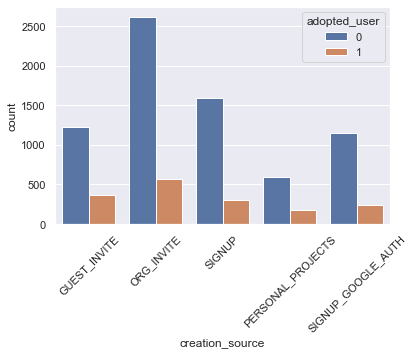

In [264]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=df_adopted, hue='adopted_user')
_ = plt.xticks(rotation=45)

The creation source does not seem to indicate strong correlation between adopted users and methods of creating an account. There does seem to be variance in ratios between adopted and not adopted from source to source. It is worth keeping and exploring. 

## Baseline Modeling 

#### We will build a baseline Random Forest model that utilizes Random Oversampling of the Minority class and observe it's performance. No need to scale the 'account duration' column, as Random Forest will not be affected by the change in scale. 

In [265]:
#prep dataframe by getting dummy variables for 'creation_source'
creation_source = pd.get_dummies(df_adopted['creation_source'], drop_first=True)
df_model = pd.concat([df_adopted, creation_source], axis=1).drop('creation_source', axis=1)
df_model

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,account_duration,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,
1,1,0,11,10803.0,38,0,0,0,0,0
2,0,0,1,316.0,196,1,1,0,0,0
3,0,0,94,1525.0,437,0,1,0,0,0
4,0,0,1,5151.0,374,0,0,0,0,0
5,0,0,193,5240.0,498,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11996,0,0,89,8263.0,266,0,1,0,0,0
11997,0,0,200,0.0,505,0,0,0,0,1
11998,1,1,83,8074.0,33,0,0,0,0,0


In [271]:
#import libararies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [273]:
#create X, y variables and train/test split 80/20
X = df_model.drop('adopted_user', axis=1)
y = df_model['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=42)

In [276]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
#use GridSearchCV to tune number of estimators
params = {'n_estimators': [10, 50, 100, 200, 400, 1000]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.7920088619768192


In [277]:
#construct RFC based on best paramters provided by CV
RF_model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=200
)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.7898016997167139
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1434
           1       0.21      0.05      0.07       331

    accuracy                           0.79      1765
   macro avg       0.51      0.50      0.48      1765
weighted avg       0.70      0.79      0.73      1765



## Suggestions and Conclusion: 
### The Random Forest Model, while we did attempt to satisfy the different in class sized with the class_weight parameter, performed poorly in the recall for the Minority class. Suggestions moving forward would be to utililze Random Undersampling, Random Oversampling, and SMOTE to see what type of sampling techniques are most beneficial to this model. It may be worth looking into engineering another feature based off of the 'creation_time' if the model does not seem to be performing well after that. 